# Importing Necessary Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

2024-06-22 08:46:34.392239: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-22 08:46:34.392331: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-22 08:46:34.495810: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Loading and Preparing the Data

In [2]:
# Load the Fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Reshape images to include channel dimension
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

# Define the input shape
input_shape = (28, 28, 1)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# Data Augmentation

In [3]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.InputLayer(input_shape=input_shape),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Model Architecture

In [4]:
# Define the improved model architecture
model = models.Sequential([
    data_augmentation,
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10)
])

# Build the model with a sample input
model.build(input_shape=(None,) + input_shape)

# Model Compilation

In [5]:
# Learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 11, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 522,122 (1.99 MB)

 Trainable params: 520,970 (1.99 MB)

 Non-trainable params: 1,152 (4.50 KB)

# Custom Callback for Progress Tracking

In [6]:
# Custom callback for progress tracking
class ProgressBar(tf.keras.callbacks.Callback):
    """Custom callback to show a progress bar for each epoch during training."""
    
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']

    def on_epoch_begin(self, epoch, logs=None):
        self.pbar = tqdm(total=self.params['steps'], desc=f'Epoch {epoch+1}/{self.epochs}')

    def on_train_batch_end(self, batch, logs=None):
        self.pbar.update(1)

    def on_epoch_end(self, epoch, logs=None):
        self.pbar.close()
        print(f"Train Loss: {logs['loss']:.4f}, Train Accuracy: {logs['accuracy']:.4f}")
        print(f"Val Loss: {logs['val_loss']:.4f}, Val Accuracy: {logs['val_accuracy']:.4f}\n")

progress_bar = ProgressBar()

# Add EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

# Model Training

In [7]:
# Train the model
history = model.fit(
    train_images, train_labels, 
    epochs=100,
    validation_data=(test_images, test_labels),
    callbacks=[progress_bar, early_stopping],
    verbose=0
)

Epoch 1/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.7050, Train Accuracy: 0.7462
Val Loss: 0.5150, Val Accuracy: 0.8200



Epoch 2/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.4975, Train Accuracy: 0.8197
Val Loss: 0.4585, Val Accuracy: 0.8327



Epoch 3/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.4423, Train Accuracy: 0.8384
Val Loss: 0.4182, Val Accuracy: 0.8482



Epoch 4/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.4088, Train Accuracy: 0.8518
Val Loss: 0.4337, Val Accuracy: 0.8370



Epoch 5/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.3876, Train Accuracy: 0.8612
Val Loss: 0.4331, Val Accuracy: 0.8285



Epoch 6/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.3660, Train Accuracy: 0.8679
Val Loss: 0.4082, Val Accuracy: 0.8510



Epoch 7/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.3540, Train Accuracy: 0.8729
Val Loss: 0.3691, Val Accuracy: 0.8617



Epoch 8/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.3375, Train Accuracy: 0.8773
Val Loss: 0.3843, Val Accuracy: 0.8655



Epoch 9/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.3287, Train Accuracy: 0.8810
Val Loss: 0.3160, Val Accuracy: 0.8853



Epoch 10/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.3182, Train Accuracy: 0.8840
Val Loss: 0.3140, Val Accuracy: 0.8844



Epoch 11/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.3092, Train Accuracy: 0.8869
Val Loss: 0.3157, Val Accuracy: 0.8842



Epoch 12/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.3044, Train Accuracy: 0.8898
Val Loss: 0.3521, Val Accuracy: 0.8770



Epoch 13/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.2945, Train Accuracy: 0.8932
Val Loss: 0.3503, Val Accuracy: 0.8745



Epoch 14/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.2931, Train Accuracy: 0.8913
Val Loss: 0.3223, Val Accuracy: 0.8841



Epoch 15/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.2830, Train Accuracy: 0.8973
Val Loss: 0.3097, Val Accuracy: 0.8899



Epoch 16/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.2787, Train Accuracy: 0.8988
Val Loss: 0.2841, Val Accuracy: 0.8963



Epoch 17/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.2720, Train Accuracy: 0.8994
Val Loss: 0.2758, Val Accuracy: 0.8996



Epoch 18/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.2729, Train Accuracy: 0.9020
Val Loss: 0.3068, Val Accuracy: 0.8921



Epoch 19/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.2662, Train Accuracy: 0.9032
Val Loss: 0.3497, Val Accuracy: 0.8725



Epoch 20/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.2580, Train Accuracy: 0.9055
Val Loss: 0.3405, Val Accuracy: 0.8767



Epoch 21/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.2594, Train Accuracy: 0.9059
Val Loss: 0.2920, Val Accuracy: 0.8970



Epoch 22/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.2524, Train Accuracy: 0.9078
Val Loss: 0.3325, Val Accuracy: 0.8881



Epoch 23/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.2465, Train Accuracy: 0.9100
Val Loss: 0.3087, Val Accuracy: 0.8880



Epoch 24/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.2487, Train Accuracy: 0.9075
Val Loss: 0.3394, Val Accuracy: 0.8875



Epoch 25/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.2434, Train Accuracy: 0.9114
Val Loss: 0.2757, Val Accuracy: 0.9007



Epoch 26/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.2406, Train Accuracy: 0.9119
Val Loss: 0.3298, Val Accuracy: 0.8784



Epoch 27/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.2425, Train Accuracy: 0.9113
Val Loss: 0.2768, Val Accuracy: 0.9015



Epoch 28/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.2365, Train Accuracy: 0.9147
Val Loss: 0.3685, Val Accuracy: 0.8635



Epoch 29/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.2306, Train Accuracy: 0.9137
Val Loss: 0.2764, Val Accuracy: 0.9014



Epoch 30/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.2312, Train Accuracy: 0.9146
Val Loss: 0.2692, Val Accuracy: 0.9054



Epoch 31/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.2282, Train Accuracy: 0.9165
Val Loss: 0.2864, Val Accuracy: 0.8949



Epoch 32/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.2245, Train Accuracy: 0.9163
Val Loss: 0.2979, Val Accuracy: 0.8921



Epoch 33/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.2202, Train Accuracy: 0.9188
Val Loss: 0.2993, Val Accuracy: 0.8995



Epoch 34/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.2223, Train Accuracy: 0.9186
Val Loss: 0.2852, Val Accuracy: 0.8981



Epoch 35/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.2168, Train Accuracy: 0.9207
Val Loss: 0.4138, Val Accuracy: 0.8815



Epoch 36/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.2174, Train Accuracy: 0.9206
Val Loss: 0.2841, Val Accuracy: 0.8961



Epoch 37/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.2156, Train Accuracy: 0.9210
Val Loss: 0.2706, Val Accuracy: 0.9067



Epoch 38/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.2121, Train Accuracy: 0.9223
Val Loss: 0.2572, Val Accuracy: 0.9099



Epoch 39/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.2151, Train Accuracy: 0.9218
Val Loss: 0.2702, Val Accuracy: 0.9057



Epoch 40/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.2098, Train Accuracy: 0.9232
Val Loss: 0.3341, Val Accuracy: 0.8799



Epoch 41/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.2090, Train Accuracy: 0.9230
Val Loss: 0.2700, Val Accuracy: 0.9075



Epoch 42/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.2085, Train Accuracy: 0.9231
Val Loss: 0.2565, Val Accuracy: 0.9098



Epoch 43/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.2050, Train Accuracy: 0.9249
Val Loss: 0.2597, Val Accuracy: 0.9086



Epoch 44/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.2021, Train Accuracy: 0.9260
Val Loss: 0.3093, Val Accuracy: 0.9020



Epoch 45/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.2017, Train Accuracy: 0.9255
Val Loss: 0.2576, Val Accuracy: 0.9139



Epoch 46/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.2017, Train Accuracy: 0.9264
Val Loss: 0.2557, Val Accuracy: 0.9135



Epoch 47/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.1957, Train Accuracy: 0.9280
Val Loss: 0.2637, Val Accuracy: 0.9089



Epoch 48/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.1966, Train Accuracy: 0.9284
Val Loss: 0.2786, Val Accuracy: 0.9033



Epoch 49/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.1942, Train Accuracy: 0.9275
Val Loss: 0.2543, Val Accuracy: 0.9122



Epoch 50/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.1935, Train Accuracy: 0.9292
Val Loss: 0.2716, Val Accuracy: 0.9073



Epoch 51/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.1957, Train Accuracy: 0.9288
Val Loss: 0.2813, Val Accuracy: 0.9017



Epoch 52/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.1881, Train Accuracy: 0.9313
Val Loss: 0.2940, Val Accuracy: 0.8986



Epoch 53/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.1891, Train Accuracy: 0.9301
Val Loss: 0.2652, Val Accuracy: 0.9105



Epoch 54/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.1905, Train Accuracy: 0.9295
Val Loss: 0.2948, Val Accuracy: 0.8975



Epoch 55/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.1856, Train Accuracy: 0.9317
Val Loss: 0.2591, Val Accuracy: 0.9115



Epoch 56/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.1858, Train Accuracy: 0.9320
Val Loss: 0.2664, Val Accuracy: 0.9093



Epoch 57/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.1856, Train Accuracy: 0.9315
Val Loss: 0.2602, Val Accuracy: 0.9116



Epoch 58/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.1837, Train Accuracy: 0.9325
Val Loss: 0.2632, Val Accuracy: 0.9110



Epoch 59/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.1840, Train Accuracy: 0.9329
Val Loss: 0.2577, Val Accuracy: 0.9104



Epoch 60/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.1821, Train Accuracy: 0.9325
Val Loss: 0.2636, Val Accuracy: 0.9090



Epoch 61/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.1816, Train Accuracy: 0.9322
Val Loss: 0.2599, Val Accuracy: 0.9114



Epoch 62/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.1769, Train Accuracy: 0.9341
Val Loss: 0.2648, Val Accuracy: 0.9099



Epoch 63/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.1800, Train Accuracy: 0.9335
Val Loss: 0.2590, Val Accuracy: 0.9135



Epoch 64/100:   0%|          | 0/1875 [00:00<?, ?it/s]

Train Loss: 0.1748, Train Accuracy: 0.9351
Val Loss: 0.2894, Val Accuracy: 0.9063



# Model Evaluation

In [8]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'\nTest accuracy: {test_acc}')

313/313 - 1s - 2ms/step - accuracy: 0.9122 - loss: 0.2543

Test accuracy: 0.9121999740600586


# Plotting Training History

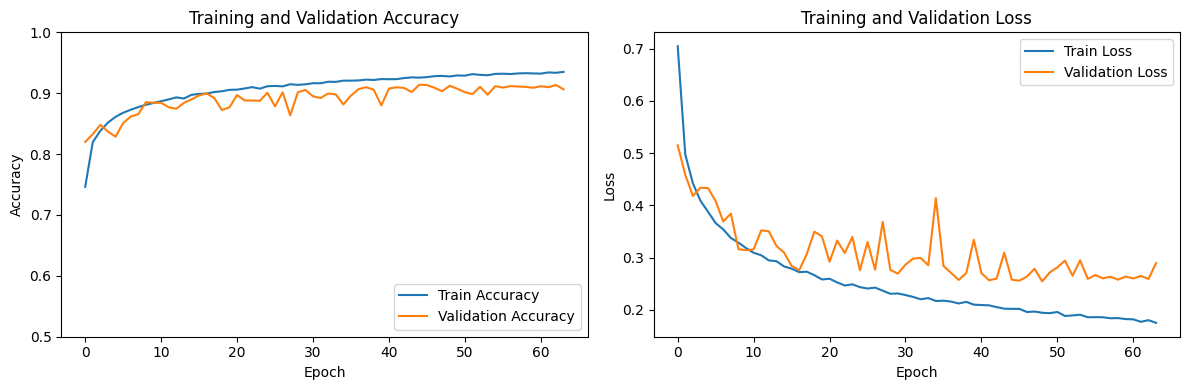

In [9]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

# Making Predictions and Plotting Results

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


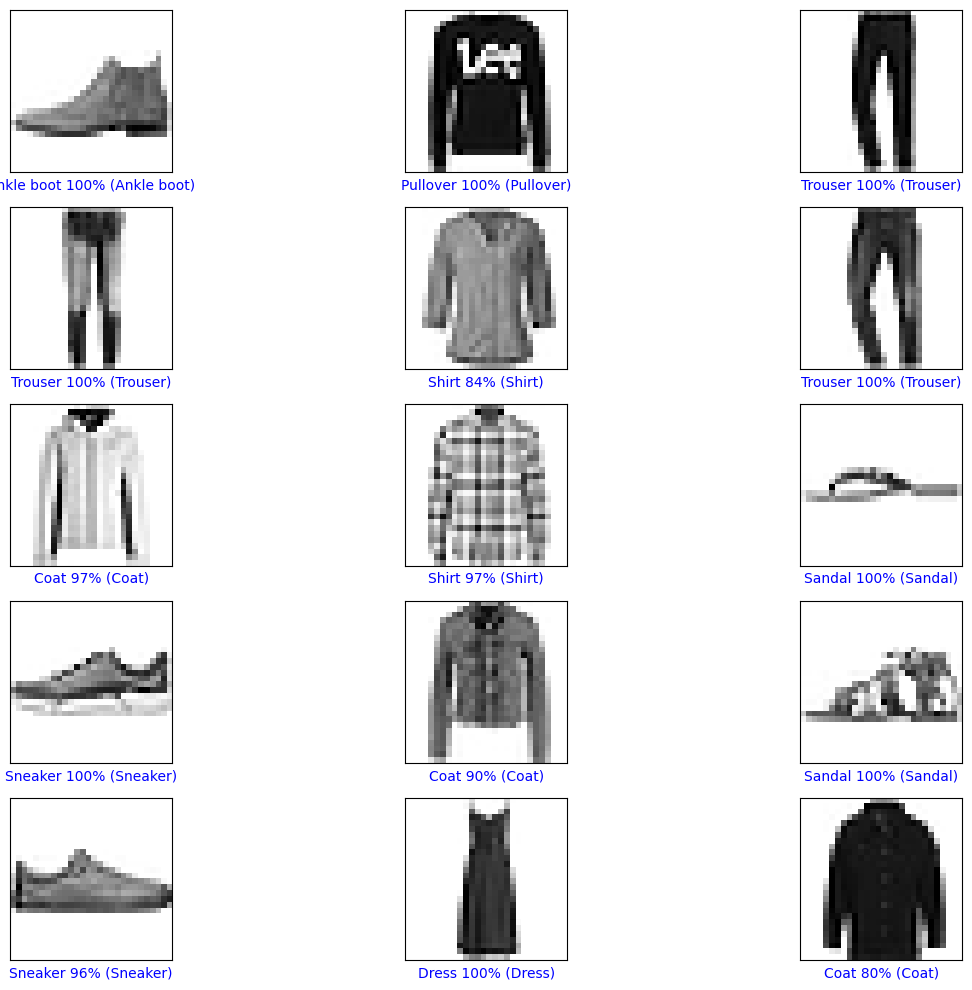

In [10]:
# Function to plot images and predictions
def plot_image(i, predictions_array, true_label, img):
    """Plot a single image with its prediction."""
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img.reshape((28,28)), cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(f"{class_names[predicted_label]} {100*np.max(predictions_array):2.0f}% "
               f"({class_names[true_label]})", color=color)

# Make predictions
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(test_images)

# Plot a grid of images with their predictions
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_images)
plt.tight_layout()
plt.show()